In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import numpy as np

2025-06-12 00:47:09.855291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749685629.868570   47878 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749685629.872765   47878 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749685629.882646   47878 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749685629.882661   47878 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749685629.882662   47878 computation_placer.cc:177] computation placer alr

In [2]:
tf.__version__

'2.19.0'

In [3]:
train_dir = 'dataset_balanceado_final/train'
validation_dir = 'dataset_balanceado_final/validation'
test_dir = 'dataset_balanceado_final/test'

Definir batch_size e image_size

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 150
BATCH_SIZE = 32

Training set -  É o conjunto de dados usado para treinar a rede

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' 
)

Found 4276 files belonging to 7 classes.


I0000 00:00:1749685632.292233   47878 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4804 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:03:00.0, compute capability: 7.5
I0000 00:00:1749685632.295785   47878 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4804 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Validation set - Usado para 'testar' o modelo durante o processo de procura da melhor combinação de hiperparâmetros.

In [6]:
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


Test set - Usado para testar o modelo depois do processo de treino

In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


### Metricas para avaliar os modelos

In [8]:
# Utiliza uma função(do sckicit-learn) para avaliar o desempenho do modelo, indicando Métricas como: 
    # f1-score do modelo
    # accuracy do modelo
    # accuracy por classe 

from sklearn.metrics import classification_report
import numpy as np

def print_classification_metrics(model, dataset, phase_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {phase_name}")
    print(classification_report(y_true, y_pred, digits=4))


# MODELO 2 (VGG16) - Optuna (sem data augmentation)

## Feature Extraction 

In [9]:
from tensorflow import keras 
from keras import layers 
from keras.applications import VGG16 # Importa a arquitetura VGG16 pré-treinada do Keras.


# Carregar a base VGG16 pré-treinada
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) # Carrega o modelo VGG16 pré-treinado no ImageNet, sem a camada do topo
conv_base.trainable = False # Congela todas as camadas da VGG16, impedindo que os seus pesos sejam atualizados durante o treino (feature extraction).

# Usar data augmentation
inputs = layers.Input(shape=(150, 150, 3)) # Define a camada de entrada do novo modelo com o formato das imagens e 3 canais (RGB)
x = keras.applications.vgg16.preprocess_input(inputs) # Aplica o pré-processamento específico da VGG16 
x = conv_base(x) # Passa as imagens (pré-processadas e aumentadas) através da base VGG16 congelada para extrair características.
x = layers.Flatten()(x) # Achata as características extraídas para um vetor 1D.
x = layers.Dense(512, activation='relu')(x) # Adiciona uma camada densa com 512 neurónios e ativação ReLU.
x = layers.Dropout(0.5)(x) # Aplica Dropout (50%) para regularização e prevenção de overfitting.
outputs = layers.Dense(7, activation='softmax')(x) # Adiciona a camada de saída densa com 7 neurónios (para 7 classes) e ativação Softmax

model_t = models.Model(inputs, outputs) # Cria o model_t

# Compilar e treinar (feature extraction)
model_t.compile( # Compila o modelo para configurar o processo de treino.
    loss='categorical_crossentropy', # Define a função de perda apropriada para classificação multi-classe.
    optimizer=keras.optimizers.RMSprop(learning_rate=0.000934755), # Configura o otimizador RMSprop com uma taxa de aprendizagem sugerida pelo optuna
    metrics=['accuracy'] # Define 'accuracy' (precisão) como a métrica a ser usada
)

history_t = model_t.fit( # Treina o modelo.
    train_dataset, # Usa o conjunto de dados de treino.
    validation_data=validation_dataset, # Usa o conjunto de dados de validação para monitorizar o desempenho.
    epochs=8 # Treina o modelo por 10 épocas.
)

Epoch 1/8


I0000 00:00:1749685635.010232   48055 service.cc:152] XLA service 0x73e1900046d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749685635.010251   48055 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1749685635.010254   48055 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-06-12 00:47:15.053971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749685635.296612   48055 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-12 00:47:15.590619: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,150,150]{3,2,1,0} %bitcast.3516,

  2/134 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.1328 - loss: 28.3495

I0000 00:00:1749685640.414680   48055 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3727 - loss: 13.0227

2025-06-12 00:47:34.938689: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[20,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,150,150]{3,2,1,0} %bitcast.3516, f32[64,3,3,3]{3,2,1,0} %bitcast.3523, f32[64]{0} %bitcast.3525), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-12 00:47:35.039389: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.c

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3731 - loss: 12.9672

2025-06-12 00:47:44.211998: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[12,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,150,150]{3,2,1,0} %bitcast.850, f32[64,3,3,3]{3,2,1,0} %bitcast.857, f32[64]{0} %bitcast.859), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-12 00:47:44.268708: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

134/134 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.3736 - loss: 12.9125 - val_accuracy: 0.5261 - val_loss: 1.5430
Epoch 2/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.5521 - loss: 1.5502 - val_accuracy: 0.5993 - val_loss: 1.5276
Epoch 3/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6292 - loss: 1.3398 - val_accuracy: 0.6563 - val_loss: 1.2842
Epoch 4/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6726 - loss: 1.1242 - val_accuracy: 0.6415 - val_loss: 1.4823
Epoch 5/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6984 - loss: 1.0145 - val_accuracy: 0.6613 - val_loss: 1.3911
Epoch 6/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7314 - loss: 0.8690 - val_accuracy: 0.6514 - val_loss: 1.4735
Epoch 7/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.7759 - loss: 0.7751 - val_accuracy: 0.6627 - val_loss: 1.6501
Epoch 8/8
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.7959 - loss: 0.7172 - val_accur

In [10]:
print_classification_metrics(model_t, test_dataset, "Modelo 2 : VGG16 (Feature Extraction com Augmentation)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-12 00:50:08.781264: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Curvas de Loss e Accuracy

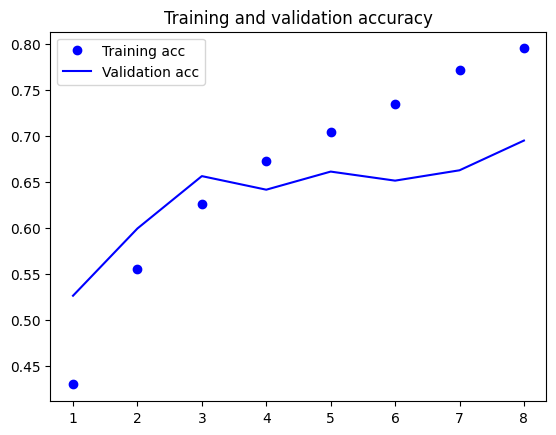

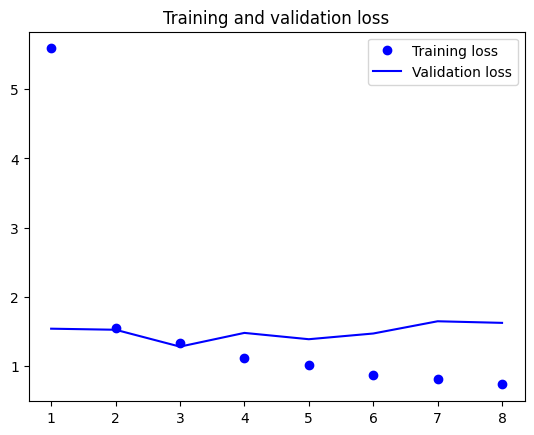

In [11]:
import matplotlib.pyplot as plt
accuracy = history_t.history['accuracy']
val_acc = history_t.history['val_accuracy']
loss = history_t.history['loss']
val_loss = history_t.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

A acurácia de treino aumenta rapidamente até cerca de 0.80, enquanto a acurácia de validação também melhora, alcançando aproximadamente 0.70. As curvas mantêm-se relativamente próximas, o que sugere bom aprendizado inicial sem sinais evidentes de overfitting, embora o número de épocas ainda seja pequeno para uma conclusão definitiva.

A loss de treino diminui visivelmente ao longo das épocas, enquanto a loss de validação apresenta variações e oscilações leves, mantendo-se num patamar entre 1.3 e 1.7. Apesar da tendência geral ser decrescente, estas flutuações indicam que o modelo ainda está a ajustar-se à tarefa, e que seria útil continuar o treino por mais épocas para avaliar se a tendência se mantém.

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-12 00:50:15.968487: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

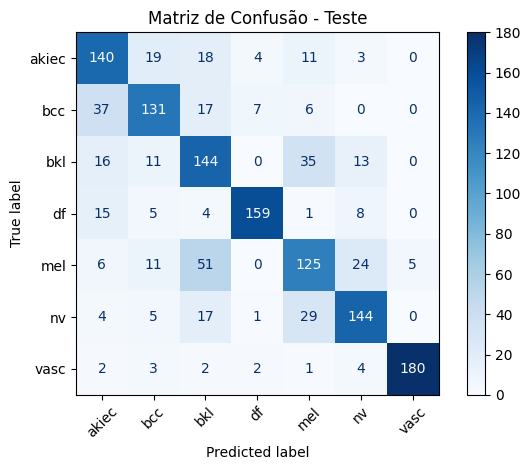

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model_t.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

O modelo apresenta bom desempenho geral, com elevada taxa de acertos nas classes ‘akiec’, ‘df’, ‘nv’ e ‘vasc’. No entanto, observa-se confusão significativa entre as classes ‘mel’, ‘bkl’ e ‘nv’, o que pode indicar dificuldade do modelo em distinguir lesões visualmente semelhantes. Ainda assim, o padrão de acertos e erros é consistente com os desafios esperados em tarefas de classificação de imagens dermatológicas.

## Fine Tuning

In [13]:
# Descongelar parte da VGG16 (últimas camadas)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:  # Descongelar as ultimas 4 camadas
    layer.trainable = False # manter as primeiras camadas congeladas

# Compilar o modelo com learning rate 
model_t.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=3.449033551761605e-05),
    metrics=['accuracy']
)

# Treinar novamente (ajustar a parte da VGG16)
history_t = model_t.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20 
)


#history = model_t.fit(
    #train_dataset, #Inicia o treino do modelo usando o conjunto de dados de treino.
    #epochs=30,  # Apesar de ter um numero alto aqui, o EarlyStopping para automaticamente
    #validation_data=validation_dataset # Usa o conjunto de dados de validação para monitorizar o desempenho do modelo em dados não vistos durante o treino.
    #,callbacks=callbacks_list
#)

Epoch 1/20


2025-06-12 00:50:17.258859: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.49 = (f32[32,512,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,9,9]{3,2,1,0} %bitcast.4353, f32[512,512,3,3]{3,2,1,0} %bitcast.4173, f32[512]{0} %bitcast.4517), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block5_conv1_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8234 - loss: 0.6356

2025-06-12 00:50:35.423069: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.49 = (f32[20,512,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,9,9]{3,2,1,0} %bitcast.4353, f32[512,512,3,3]{3,2,1,0} %bitcast.4173, f32[512]{0} %bitcast.4517), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block5_conv1_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.8235 - loss: 0.6347 - val_accuracy: 0.7042 - val_loss: 1.5173
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.8376 - loss: 0.5003 - val_accuracy: 0.6993 - val_loss: 1.4958
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.8523 - loss: 0.4644 - val_accuracy: 0.7028 - val_loss: 1.4378
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.8542 - loss: 0.4492 - val_accuracy: 0.6993 - val_loss: 1.4232
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.8521 - loss: 0.4472 - val_accuracy: 0.7056 - val_loss: 1.4145
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.8640 - loss: 0.3777 - val_accuracy: 0.7063 - val_loss: 1.4244
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.8681 - loss: 0.3603 - val_accuracy: 0.7113 - val_loss: 1.4146
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.8692 - loss: 0.3601 - val

In [14]:
print_classification_metrics(model_t, test_dataset, "Modelo 2 : Fine-tuning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Curvas de Loss e Accuracy

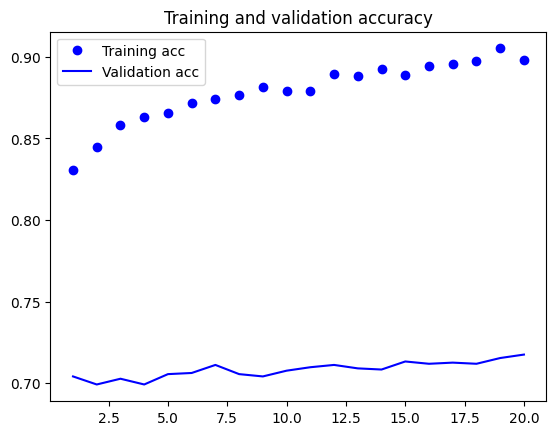

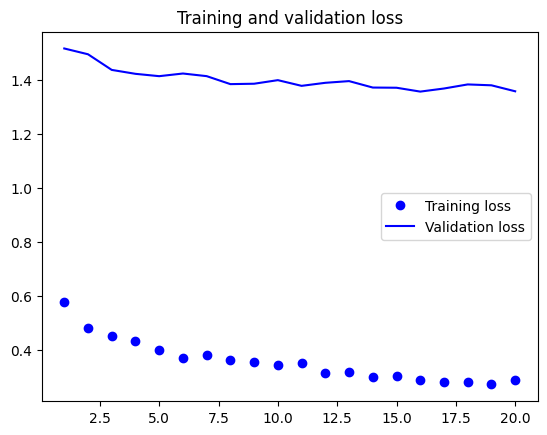

In [15]:
import matplotlib.pyplot as plt
accuracy = history_t.history['accuracy']
val_acc = history_t.history['val_accuracy']
loss = history_t.history['loss']
val_loss = history_t.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

A acurácia de treino aumenta de forma constante, atingindo cerca de 0.90, enquanto a acurácia de validação permanece praticamente estável em torno de 0.70. Essa discrepância crescente entre as curvas indica que o modelo está a sofrer de overfitting, ou seja, está a aprender bem os dados de treino, mas não consegue generalizar para novos dados.

A loss de treino diminui continuamente, enquanto a loss de validação permanece alta e praticamente inalterada ao longo das épocas. Isso reforça o diagnóstico de overfitting e sugere que o modelo está a memorizar os exemplos de treino sem conseguir melhorar no conjunto de validação.

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-12 00:57:46.550179: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

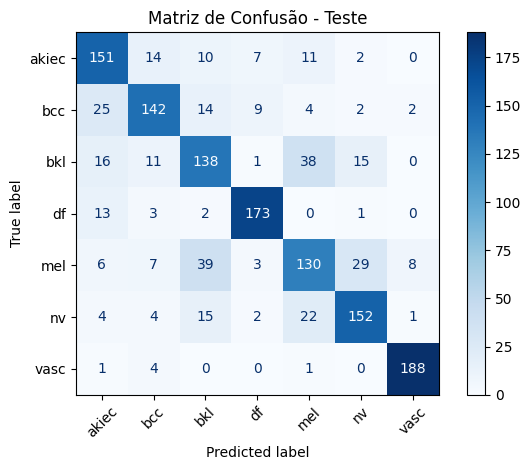

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model_t.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

O modelo demonstra bom desempenho geral, com elevado número de classificações corretas nas classes ‘akiec’, ‘df’, ‘nv’ e ‘vasc’. Ainda assim, persistem confusões importantes entre as classes ‘bkl’, ‘mel’ e ‘nv’, o que é comum devido à semelhança visual entre essas lesões. Essas trocas podem impactar a performance clínica e sugerem a necessidade de mais dados ou técnicas para reforçar a distinção entre essas categorias.

## Salvar o Modelo

In [ ]:
model_t.save("modelt_3B_optuna_sem_data_aug_RMS_SGD.keras")